 <a name="top"></a>
# Understanding how medGAN works (with count features)

Author: [Sylvain Combettes](https://github.com/sylvaincom).

Edward Choi's original repository: [medgan](https://github.com/mp2893/medgan). <br/>
My own medGAN repository (that is based on Edward Choi's work): [medgan](https://github.com/sylvaincom/medgan-tips).

The final goal of my project is to use medGAN on my own dataset (electronic health records). For that, I first need to understand how medGAN works. In this notebook, I provide a few code cells and explanations that can help better understand and run medGAN. Because there are some confidentiality issues with the MIMIC-III dataset, I cleared the output of the cells.

Before reading this notebook, be sure to have read [A few additional tips on how to run Edward Choi's medGAN](https://github.com/sylvaincom/medgan-tips/blob/master/01_tips-for-medgan.md).

---
### Tables of Contents

- [Loading the MIMIC-III dataset](#load-mimic)
- [Using process_`mimic.py` and `medgan.py` to generate the fake realistic data](#run)
- [How to interpret `gen-samples.npy`?](#gen-samples)
- [Comparing the (fake) generated samples to the real-life original ones](#comparison)

---
### Imports

In [1]:
import numpy as np
import os
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

---
# Loading the MIMIC-III dataset <a name="load-mimic"></a>

## `ADMISSIONS.csv` file

In [2]:
df_adm = pd.read_csv("ADMISSIONS.csv")
print(df_adm.shape)
df_adm.head()

(58976, 19)


,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


Do we have a lot of missing values?

In [3]:
n,p = df_adm.shape
for f in df_adm:
    percentage = sum(df_adm[f].isna())*100/n
    if percentage>0:
        print('Missing values in {}: {}%'.format(f, percentage))

Missing values in DEATHTIME: 90.07392837764515%
Missing values in LANGUAGE: 42.953065653825284%
Missing values in RELIGION: 0.7765870862723819%
Missing values in MARITAL_STATUS: 17.17308735756918%
Missing values in EDREGTIME: 47.644804666304935%
Missing values in EDOUTTIME: 47.644804666304935%
Missing values in DIAGNOSIS: 0.0423901247965274%


## `DIAGNOSES_ICD.csv` file

In [4]:
df_ICD = pd.read_csv('DIAGNOSES_ICD.csv')
print(df_ICD.shape)
df_ICD.head()

(651047, 5)


,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1.0,40301
1,1298,109,172335,2.0,486
2,1299,109,172335,3.0,58281
3,1300,109,172335,4.0,5855
4,1301,109,172335,5.0,4254


Do we have a lot of missing values?

In [5]:
n,p = df_ICD.shape
for f in df_ICD:
    percentage = sum(df_ICD[f].isna())*100/n
    if percentage>0:
        print('Missing values in {}: {}%'.format(f, percentage))

Missing values in SEQ_NUM: 0.007219140860798068%
Missing values in ICD9_CODE: 0.007219140860798068%


We check if our dataset is balanced. Does one `ICD9_CODE` appear distinctly more than others in proportion?

In [6]:
df_ICD['ICD9_CODE'].value_counts(normalize=True).head()

4019     0.031802
4280     0.020140
42731    0.019802
41401    0.019092
5849     0.014008
Name: ICD9_CODE, dtype: float64

---
# Using `process_mimic.py` and `medgan.py` to generate the fake realistic data <a name="run"></a>

This step is detailed in [A few additional tips on how to run Edward Choi's medGAN
](https://github.com/sylvaincom/medgan/blob/master/tips-for-medgan.md).

In short, in the Anaconda prompt, we run:
```
cd C:\Users\<username>\Documents\mimic_count
python process_mimic.py ADMISSIONS.csv DIAGNOSES_ICD.csv training-data "count"
mkdir generated
python medgan.py training-data.matrix ./generated/samples --data_type="count"
python medgan.py training-data.matrix gen-samples --model_file=./generated/samples-999 --generate_data=True --data_type="count"
```
Some default values are `n_epoch=1000` and `n_pretrain_epoch=100`. The computing time took more than 5 hours for me.

From now on, whenever we refer to input or output, we refer to the input and output of `medgan.py` (unless specified otherwise).

---
# How to interpret `gen-samples.npy`? <a name="gen-samples"></a>

We load the `gen-samples.npy` file which is `medgan.py`'s output:

In [7]:
output = np.load('gen-samples.npy')
df_output = pd.DataFrame(output)
print(df_output.shape)
df_output.head()

(10000, 1071)


,0,1,2,3,4,5,6,7,8,9,...,1061,1062,1063,1064,1065,1066,1067,1068,1069,1070
0,0.0,0.0,0.0,0.0,0.0,1.254845,0.360170,0.00000,0.0,2.172746,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,1.937719,0.00000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,2.314015,1.987715,0.32321,0.0,0.013287,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


What is the range of the values?

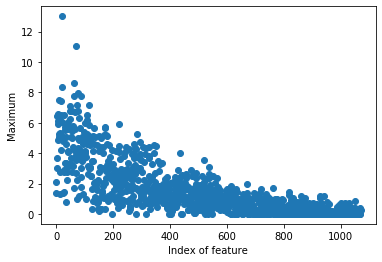

In [8]:
plt.plot(df_output.max(axis=0).tolist(), 'o')
plt.xlabel('Index of feature')
plt.ylabel('Maximum')
plt.show()

Some questions about this data frame:
* What do the columns correspond to? They do not look like `ADMISSIONS.csv` nor `DIAGNOSIS_ICD.csv`.
* What do the rows correspond to?
* Why are is the maximum value of each column inferior to 1?
* Why are the values not count values?

We can find some answers in an issue opened in Edward Choi's GitHub: [How to interpret the samples?](https://github.com/mp2893/medgan/issues/3). In order to understand the output `gen-samples.npy` of `medgan.py`, we are going to back to the input of `medgan.py`: the output of `process_mimic.py`.

Actually, as in the `.matrix` file, each row corresponds to a single synthetic patient and each column corresponds to a specific ICD9 diagnosis code. We can use the `.types` file created by `process_mimic.py` to map each column to a specific ICD9 diagnosis code. Read the beginning part of the source code of `process_mimic.py` for more information about `.types` file:
```python
# Output files
# <output file>.pids: cPickled Python list of unique Patient IDs. Used for intermediate processing
# <output file>.matrix: Numpy float32 matrix. Each row corresponds to a patient. Each column corresponds to a ICD9 diagnosis code.
# <output file>.types: cPickled Python dictionary that maps string diagnosis codes to integer diagnosis codes.
```

What is ICD-9? See [ICD-9](https://en.wikipedia.org/wiki/International_Statistical_Classification_of_Diseases_and_Related_Health_Problems#ICD-9) and [List of ICD-9 codes](https://en.wikipedia.org/wiki/List_of_ICD-9_codes).

We need to round the values ourselves:

In [9]:
df_output = df_output.round(0)
df_output.head()

,0,1,2,3,4,5,6,7,8,9,...,1061,1062,1063,1064,1065,1066,1067,1068,1069,1070
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We claim that we should delete the rows with missing values (if there are any):

In [10]:
df_output = pd.DataFrame.dropna(df_output)
print(df_output.shape)

(10000, 1071)


Indeed, in line 406 of `medgan.py`, it is written `nSamples=10000`.

## Understanding the `.types` file (an ouput of `process_mimic.py`)

_cPickled Python dictionary that maps string diagnosis codes to integer diagnosis codes._

In [11]:
map_dict = pickle.load(open('training-data.types', 'rb'))
print(type(map_dict))
print('An excerpt is:', dict(list(map_dict.items())[0:5]))

<class 'dict'>
An excerpt is: {'D_967': 0, 'D_969': 1, 'D_E950': 2, 'D_348': 3, 'D_296': 4}


Thus, as its name suggests, `process_mimic.py` is really dependent on the MIMIC-III dataset. We probably will not use `process_mimic.py` on our own dataset and only run `medgan.py`. Out of `process_mimic.py`, we only need to understand how the generated `.matrix` file is constructed (lines 109 to 119).

## Understanding the `.pids` file (an ouput of `process_mimic.py`)

_cPickled Python list of unique Patient IDs. Used for intermediate processing_

In [12]:
id_list = pickle.load(open('training-data.pids', 'rb'))
print(type(id_list))
print('An excerpt is:', id_list[:10])

<class 'list'>
An excerpt is: [22, 23, 24, 25, 26, 27, 28, 30, 31, 32]


## Understanding the `.matrix` file (an ouput of `process_mimic.py` and the input of `medgan.py`)

_Numpy float32 matrix. Each row corresponds to a patient. Each column corresponds to a ICD9 diagnosis code._

In [13]:
input_data_array = pickle.load(open('training-data.matrix', 'rb'))
print(type(input_data_array))
input_data_array

<class 'numpy.ndarray'>


array([[1., 1., 2., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [14]:
df_input = pd.DataFrame(input_data_array)
print(df_input.shape)
df_input.head(10)

(46520, 1071)


,0,1,2,3,4,5,6,7,8,9,...,1061,1062,1063,1064,1065,1066,1067,1068,1069,1070
0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,2.0,1.0,1.0,2.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


What is the range of the values?

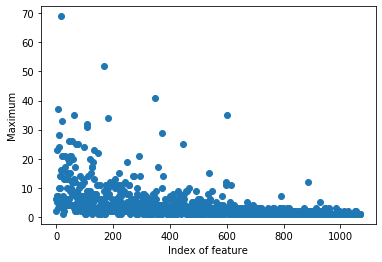

In [15]:
plt.plot(df_input.max(axis=0).tolist(), 'o')
plt.xlabel('Index of feature')
plt.ylabel('Maximum')
plt.show()

As we chose, the input data has count values. However, contrary to the input data, the maximum of each variable is not 1. 

We can note that the input of `medgan` and the [output](#gen-samples) of `medgan` have the same number of columns. Thus, `gen-samples.npy` is a (fake) realistic generated dataset corresponding to the `.matrix` file.

---
# Comparing the (fake) generated samples to the real-life original ones  <a name="comparison"></a>

In this section, we wish to compare the accuracy of the (fake) generated dataset considering the original one. Contrary to binary data, we can no longer use dimension-wise probability.

Taking the boxplot of each variable is not efficient for visualisation.

## With statistical indicators: mean, median, variance, quantile

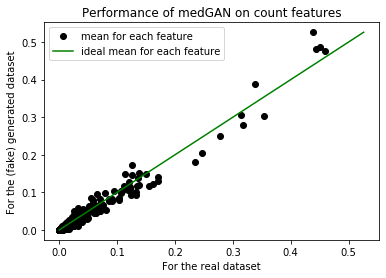

In [16]:
input_mean = df_input.mean().tolist()
output_mean = df_output.mean().tolist()

start = min(np.min(input_mean), np.min(output_mean))
stop = max(np.max(input_mean), np.max(output_mean))
p = df_input.shape[1]
X = np.linspace(start, stop, num=p+1)

plt.plot(input_mean, output_mean, 'ok', X, X, '-g');

plt.legend(['mean for each feature', 'ideal mean for each feature'])
plt.title('Performance of medGAN on count features')
plt.xlabel('For the real dataset')
plt.ylabel('For the (fake) generated dataset')
plt.show()

The values of the x-axis and the y-axis are ordered.

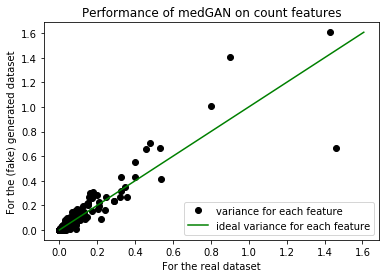

In [17]:
input_var = df_input.var().tolist()
output_var = df_output.var().tolist()

start = min(np.min(input_var), np.min(output_var))
stop = max(np.max(input_var), np.max(output_var))
p = df_input.shape[1]
X = np.linspace(start, stop, num=p+1)

plt.plot(input_var, output_var, 'ok', X, X, '-g');

plt.legend(['variance for each feature', 'ideal variance for each feature'])
plt.title('Performance of medGAN on count features')
plt.xlabel('For the real dataset')
plt.ylabel('For the (fake) generated dataset')
plt.show()

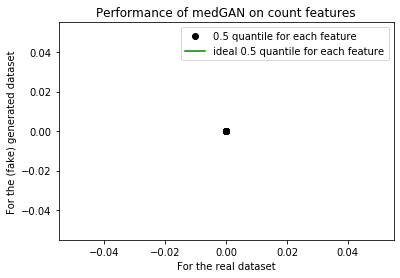

In [18]:
qt = 0.5 # choose quantile between 0 and 1
input_qt = df_input.quantile(qt).tolist()
output_qt = df_output.quantile(qt).tolist()

start = min(np.min(input_qt), np.min(output_qt))
stop = max(np.max(input_qt), np.max(output_qt))
p = df_input.shape[1]
X = np.linspace(start, stop, num=p+1)

plt.plot(input_qt, output_qt, 'ok', X, X, '-g');

plt.legend(['%s quantile for each feature' %(qt), 'ideal %s quantile for each feature' %(qt)])
plt.title('Performance of medGAN on count features')
plt.xlabel('For the real dataset')
plt.ylabel('For the (fake) generated dataset')
plt.show()

## With correlation matrix

In [ ]:
# corr_mat = df_input.corr()

The computing time is too long.

---
Back to [top](#top).